<a href="https://colab.research.google.com/github/payalnpatel/payalnpatel.github.io/blob/master/Patel%2CPayal_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Payal Patel

Advanced Big Data - HW #2 

Random Forest Model using Banking Attrition Data

### **Install PySpark Dependencies**

In [0]:
!rm spark-2.4.5-bin-hadoop2.7.tgz
!wget --no-cookies --no-check-certificate https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar zxvf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark
!pip install handyspark

### **Load Data**

In [2]:
!wget https://raw.githubusercontent.com/payalnpatel/Data/master/banking_attrition.csv

--2020-03-29 19:49:06--  https://raw.githubusercontent.com/payalnpatel/Data/master/banking_attrition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021593 (3.8M) [text/plain]
Saving to: ‘banking_attrition.csv.1’

banking_attrition.c 100%[===================>]   3.83M  --.-KB/s    in 0.08s   

2020-03-29 19:49:06 (45.9 MB/s) - ‘banking_attrition.csv.1’ saved [4021593/4021593]



### **Import Python/Spark Libraries**

In [0]:
import os
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import datetime, time
import re, random, sys
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, IntegerType, StringType, FloatType, LongType, DateType
from pyspark.sql.functions import struct, array, lit, monotonically_increasing_id, col, expr, when, concat, udf, split, size, lag, count, isnull
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import GBTRegressor, LinearRegression, GeneralizedLinearRegression, RandomForestRegressor
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, countDistinct
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator
from handyspark import *


### **Create Spark Session**

In [0]:
spark = SparkSession.builder.appName("Spark ML Assignment").master("local[*]").getOrCreate()

### **Load CSV Data Into Spark DataFrame**

In [0]:
bankData = spark.read.csv('banking_attrition.csv', header=True, inferSchema=True)

### **Data Exploration**

In [6]:
print( '\nTotal Records: ' + str(bankData.count()) + '\n')


Total Records: 45211



In [7]:
bankData.printSchema()

root
 |-- uid: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_group: string (nullable = true)
 |-- profession: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- balance: string (nullable = true)
 |-- membership: string (nullable = true)
 |-- charges: integer (nullable = true)
 |-- customer_contacts: integer (nullable = true)
 |-- attrition: integer (nullable = true)



In [0]:
column_names = bankData.columns
num_cols = ['age', 'charges', 'customer_contacts']
cat_cols = ['age_group', 'profession', 'marital_status', 'education', 'default', 'housing', 'loan', 'gender', 'balance', 'membership']
bankDataPandas = bankData.toPandas()

In [9]:
# summary stats for numeric variables 
bankData.describe(num_cols).show()

+-------+------------------+------------------+------------------+
|summary|               age|           charges| customer_contacts|
+-------+------------------+------------------+------------------+
|  count|             45211|             45211|             45211|
|   mean| 41.06354648205083|123.77065315962929| 1.944593129990489|
| stddev|11.678363426789717| 90.36019089570658|2.1048085675863932|
|    min|                18|                 0|                 0|
|    max|                95|               366|                 9|
+-------+------------------+------------------+------------------+



In [10]:
bankData.groupBy('gender').avg().collect()

[Row(gender='female', avg(uid)=1022624.9466671876, avg(age)=40.27791669922638, avg(charges)=142.11881691021333, avg(customer_contacts)=2.0891224505743535, avg(attrition)=0.31288583261701963),
 Row(gender='male', avg(uid)=1022581.2805729724, avg(age)=42.08854564918183, avg(charges)=99.83208441657746, avg(customer_contacts)=1.7560279349543764, avg(attrition)=0.11173981750522506)]

In [11]:
#frequency counts for categorical variables
for column in column_names:
  col_num_unique = bankData.select(column).distinct().count()
  if col_num_unique < 10:
    bankData.groupBy(column).count().show()

+---------+-----+
|age_group|count|
+---------+-----+
|      40s| 9748|
|      80s|  107|
|      70s|  362|
|      90s|    6|
|      20s| 8044|
|      50s|11417|
|      60s| 1091|
|      U20|   36|
|      30s|14400|
+---------+-----+

+--------------+-----+
|marital_status|count|
+--------------+-----+
|      divorced|11213|
|       married|20043|
|        single|13955|
+--------------+-----+

+-----------+-----+
|  education|count|
+-----------+-----+
|   graduate|26508|
|    college| 4931|
|    unknown| 1342|
|high school|12430|
+-----------+-----+

+-------+-----+
|default|count|
+-------+-----+
|     no|44396|
|    yes|  815|
+-------+-----+

+-------+-----+
|housing|count|
+-------+-----+
|     no|20081|
|    yes|25130|
+-------+-----+

+----+-----+
|loan|count|
+----+-----+
|  no|37967|
| yes| 7244|
+----+-----+

+------+-----+
|gender|count|
+------+-----+
|female|25594|
|  male|19617|
+------+-----+

+-------------+-----+
|      balance|count|
+-------------+-----+
|  $10k - $5

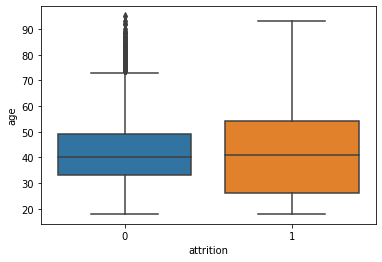

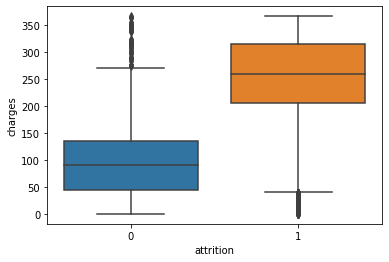

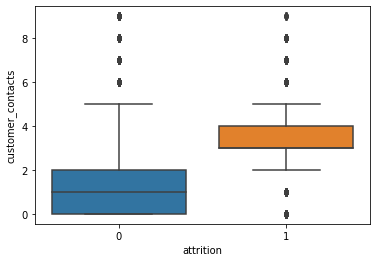

In [12]:
#box plots by attrition status 
fignum = 10
for i in num_cols:
  plt.figure(fignum)
  sns.boxplot(data=bankDataPandas, x='attrition', y=i)
  fignum = fignum+1

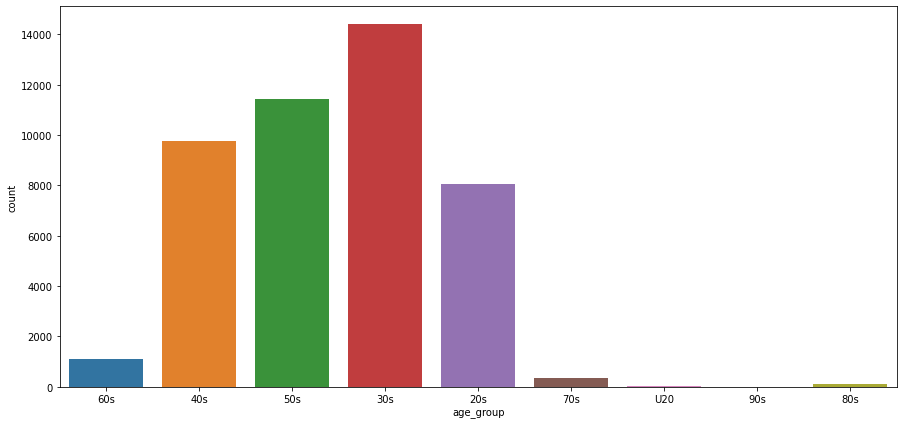

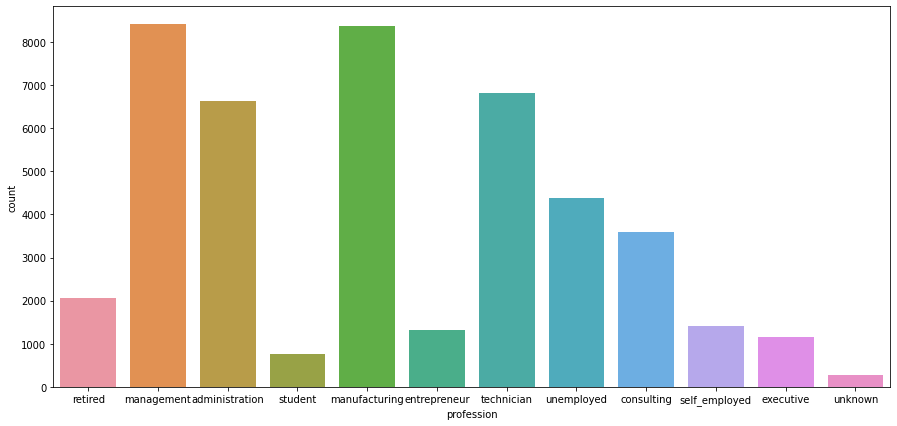

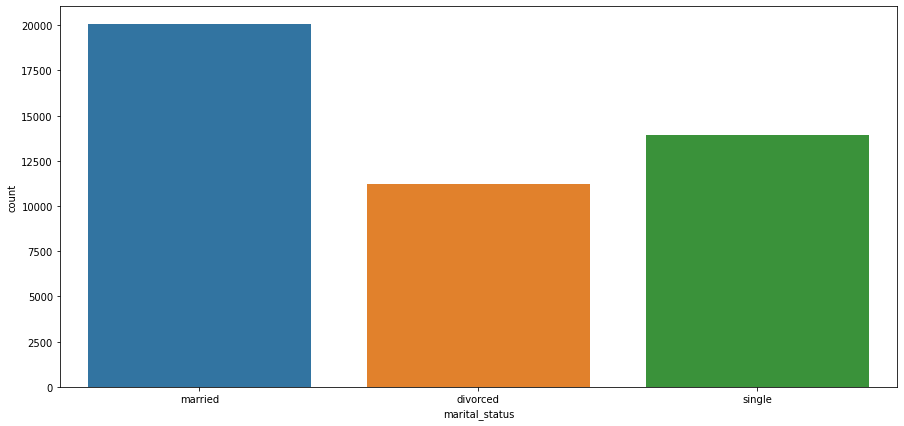

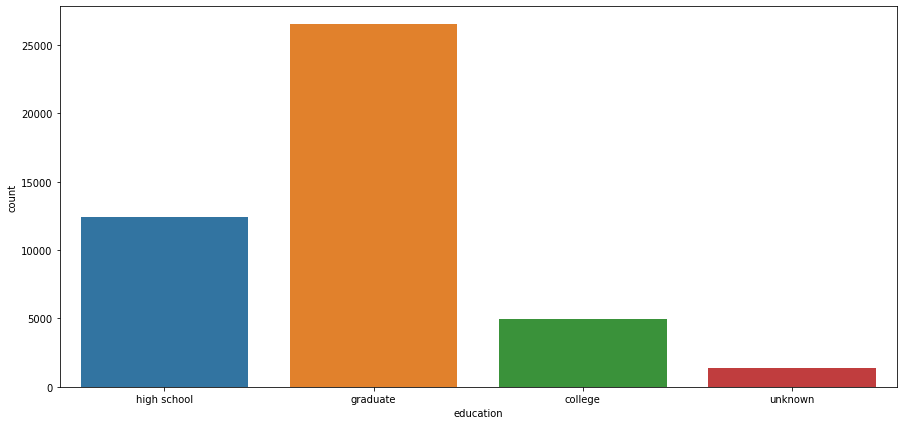

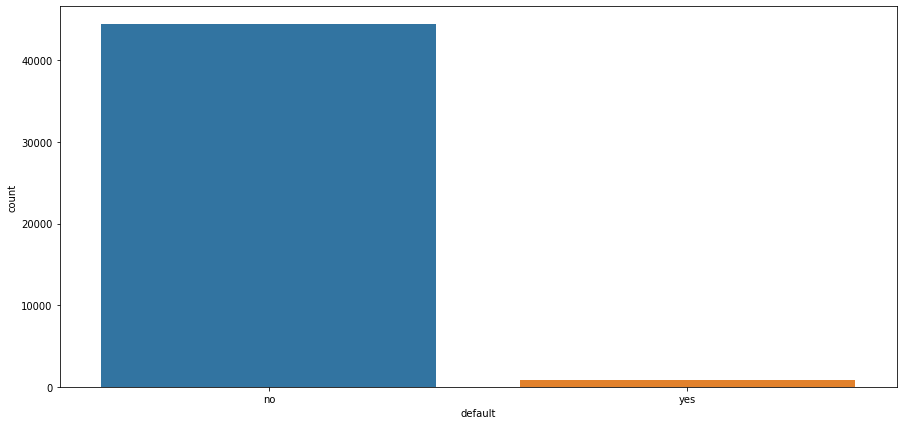

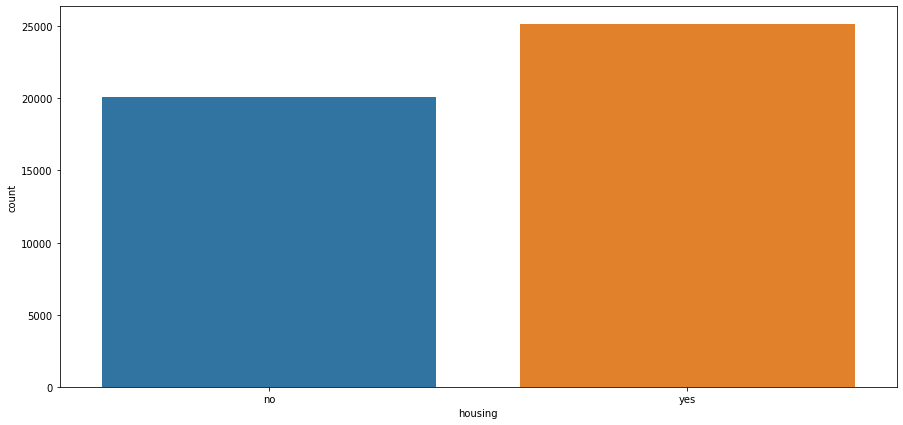

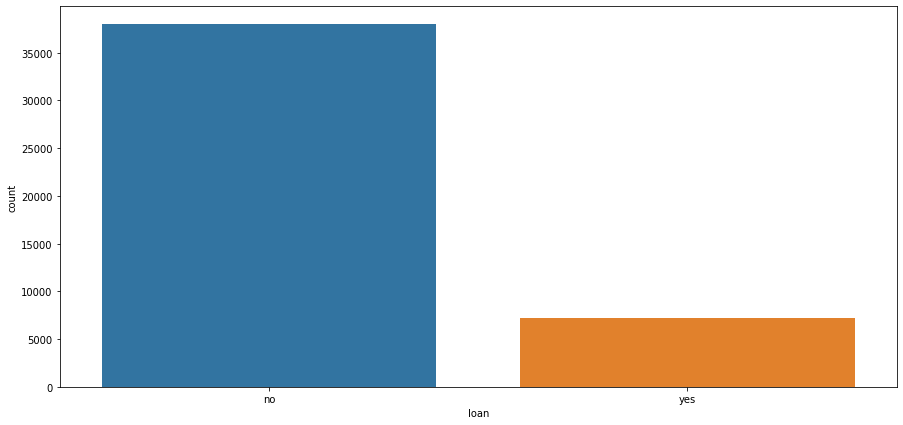

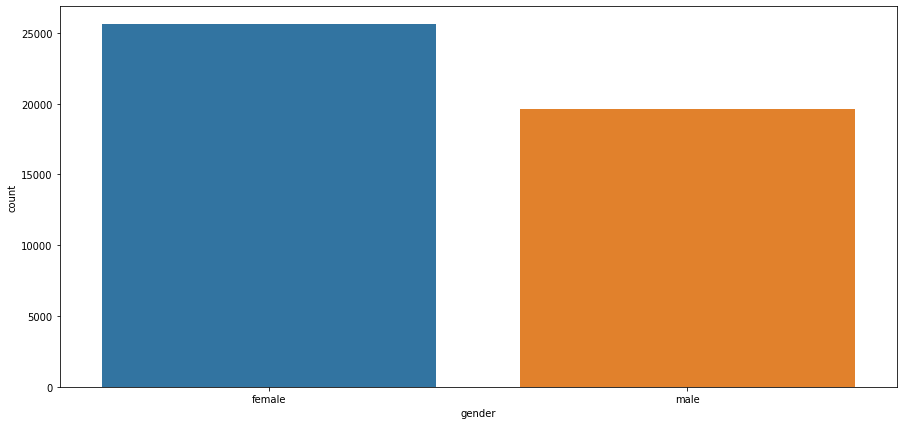

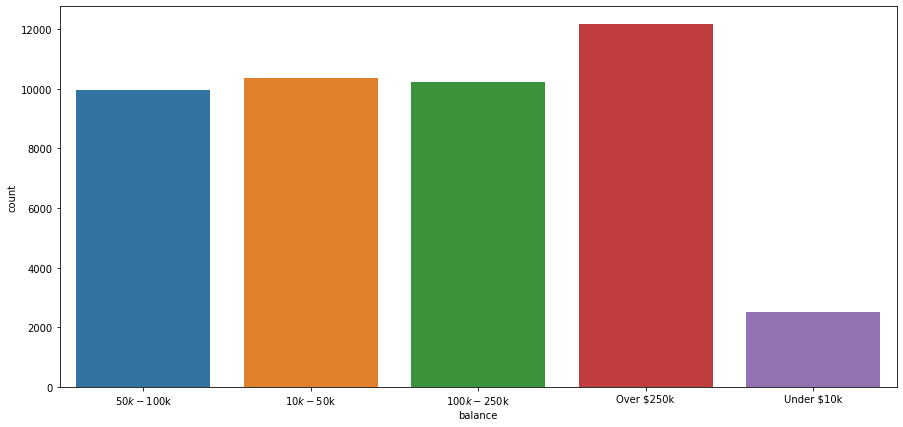

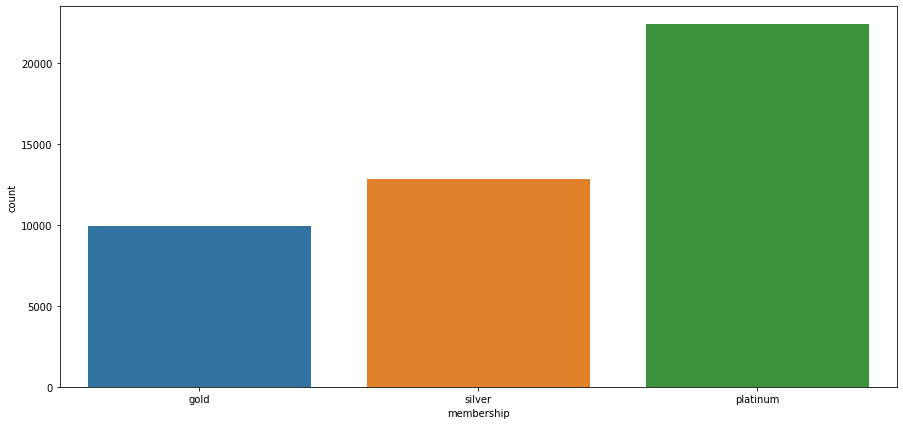

In [13]:
# count plots for categorical variables
fignum = 15
for i in cat_cols:
  plt.figure(fignum, figsize=(15,7))
  sns.countplot(x=i, data = bankDataPandas)
  fignum = fignum+1

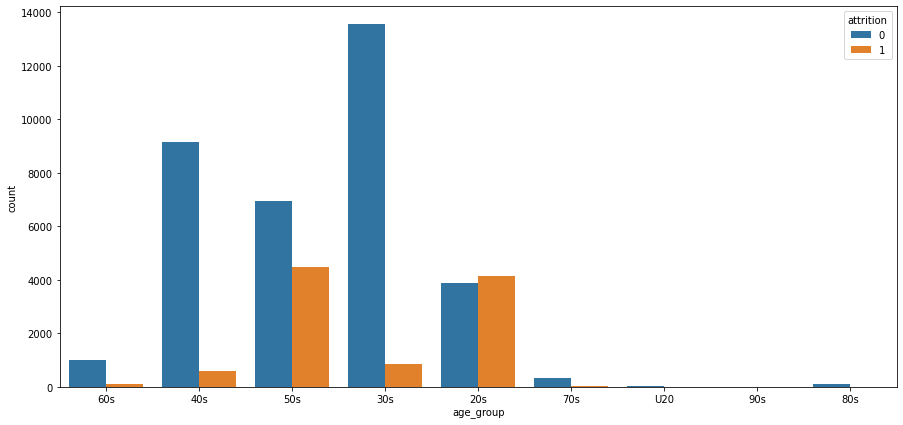

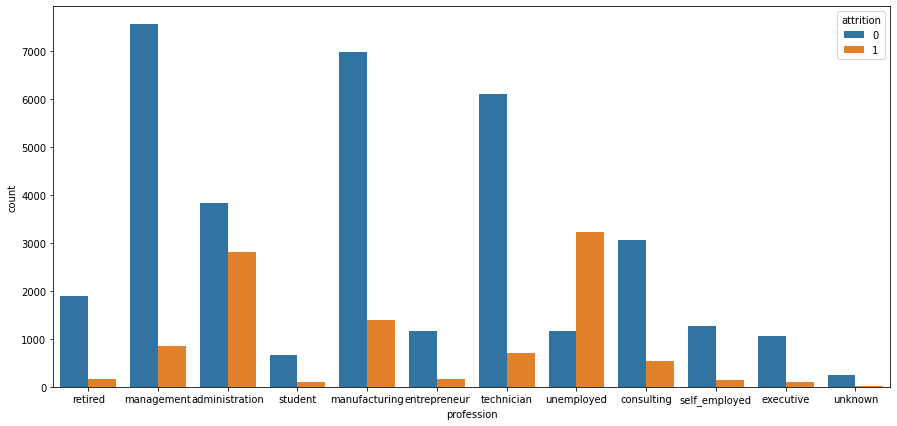

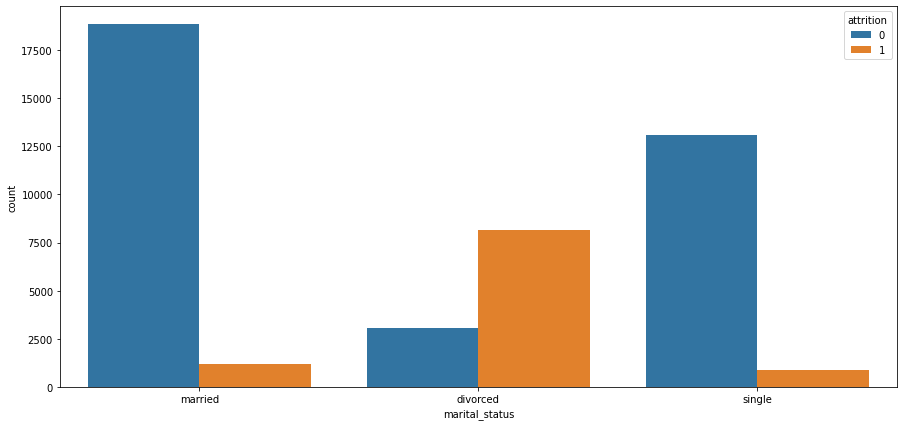

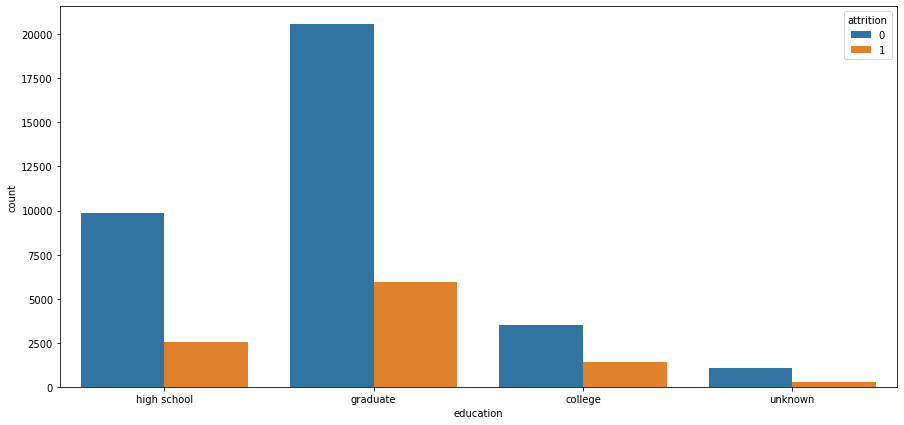

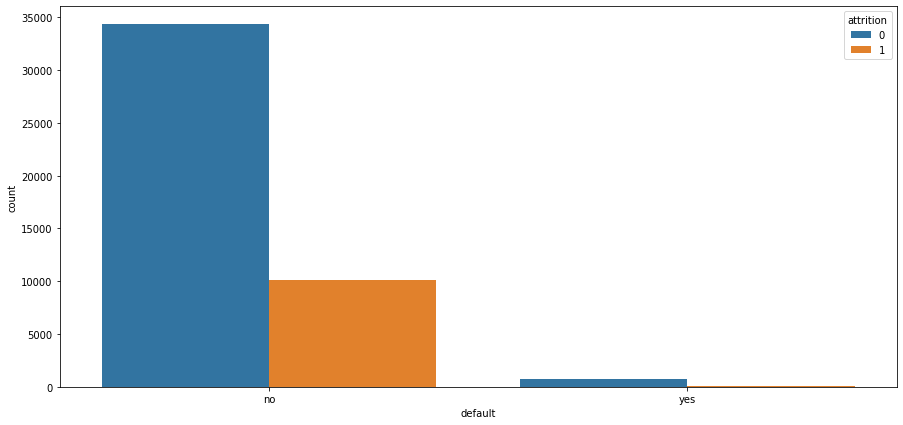

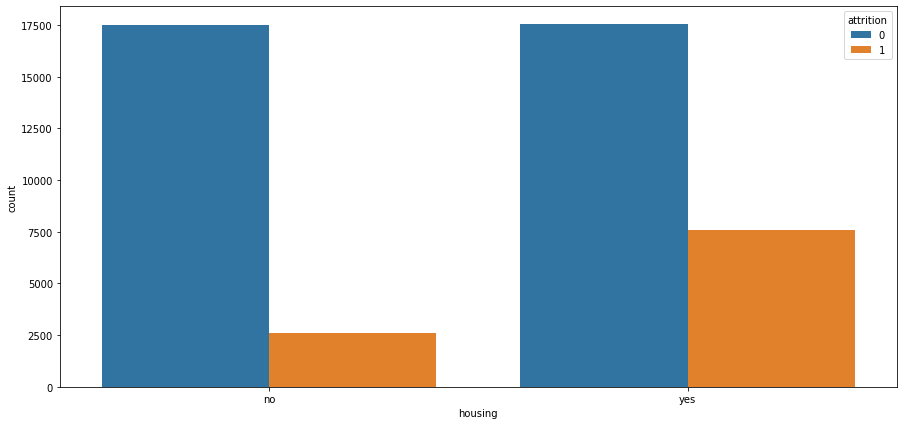

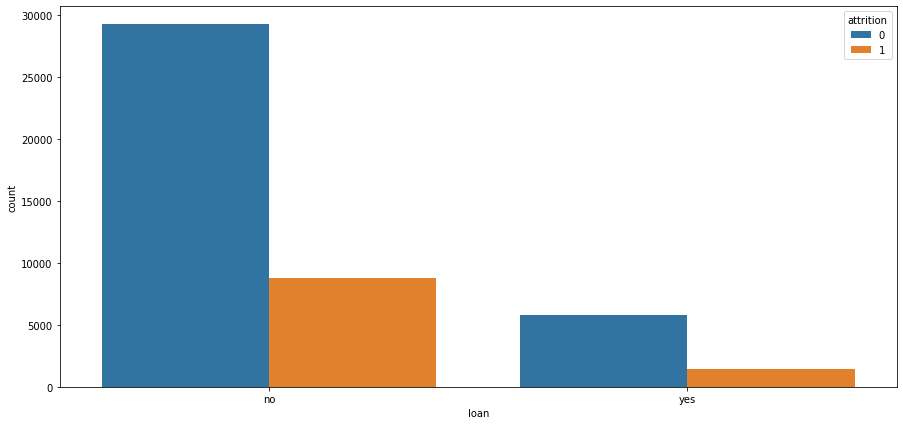

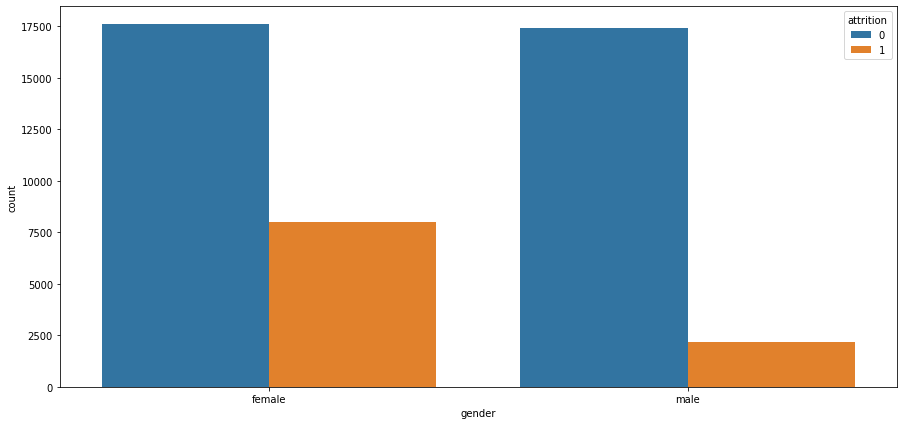

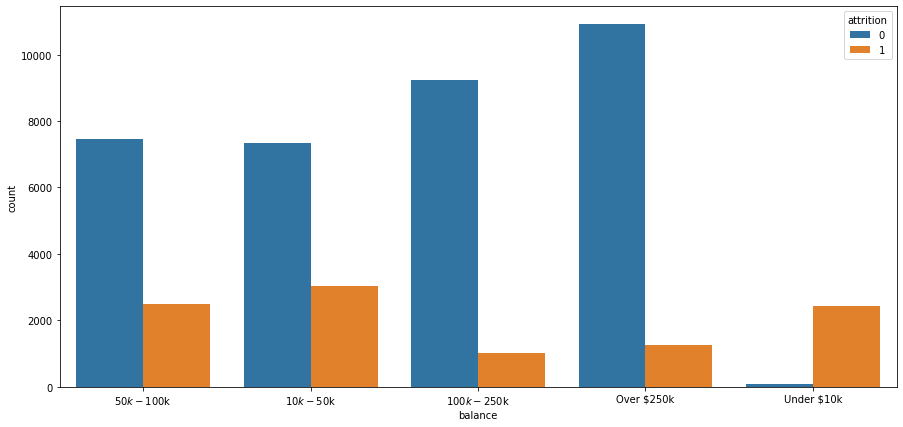

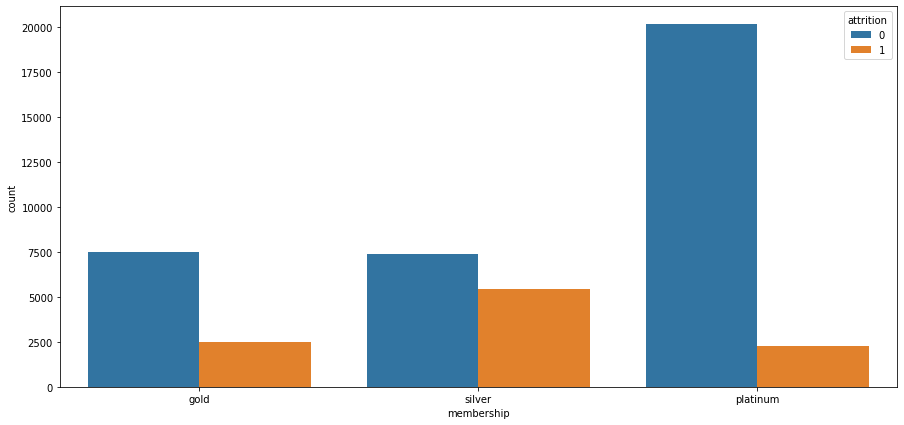

In [14]:
#count plots for categorical variables (by attrition status)
fignum = 30
for i in cat_cols:
  plt.figure(fignum, figsize=(15,7))
  sns.countplot(x=i, hue="attrition", data=bankDataPandas)
  fignum = fignum+1

<Figure size 432x288 with 0 Axes>

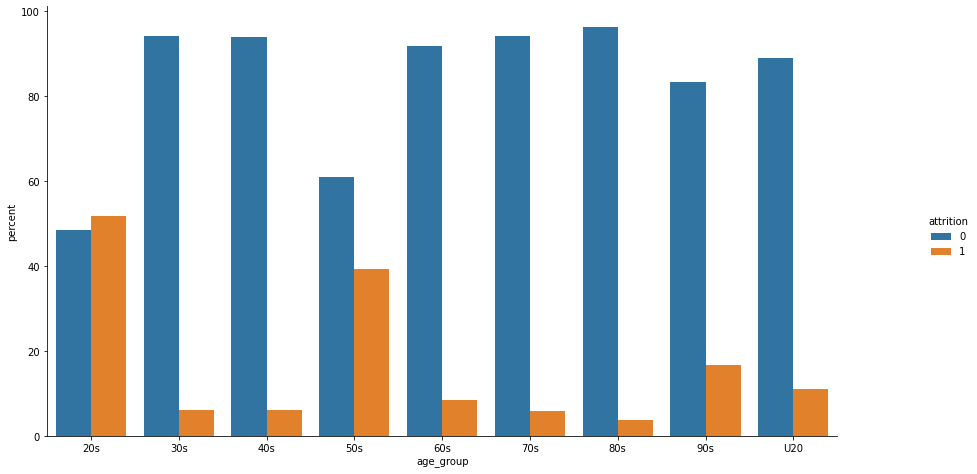

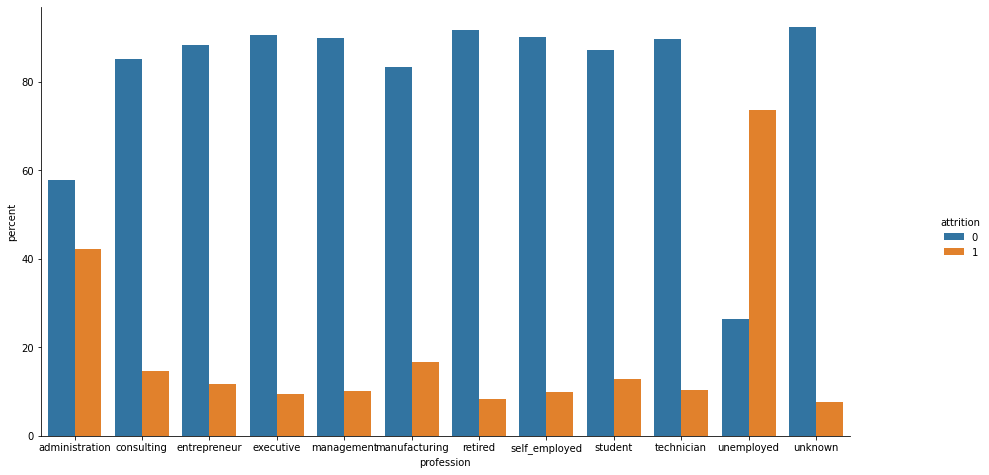

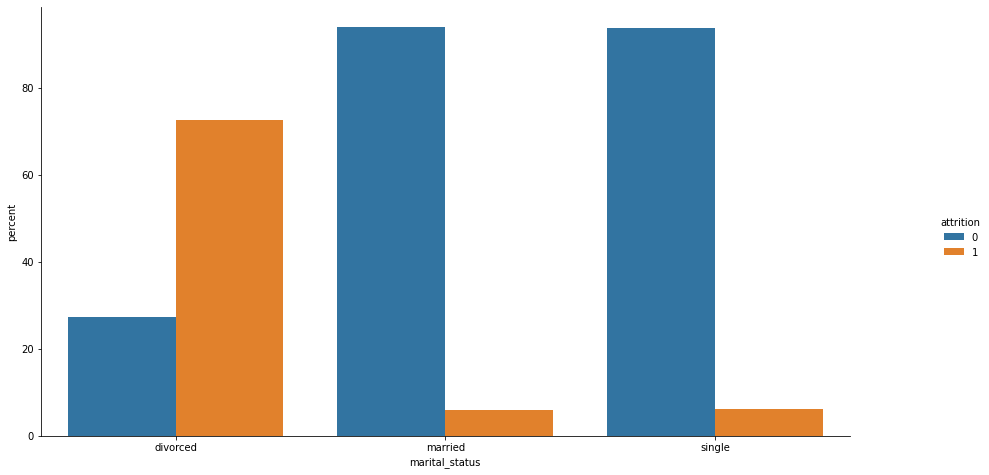

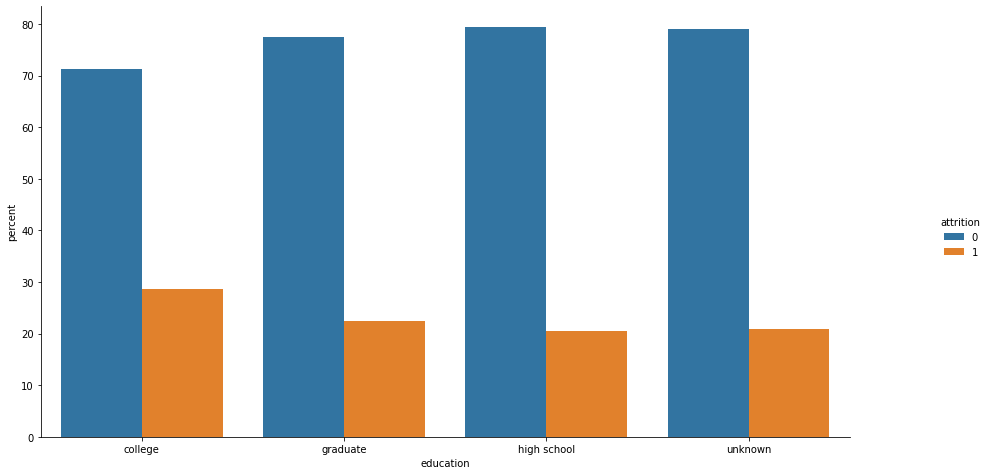

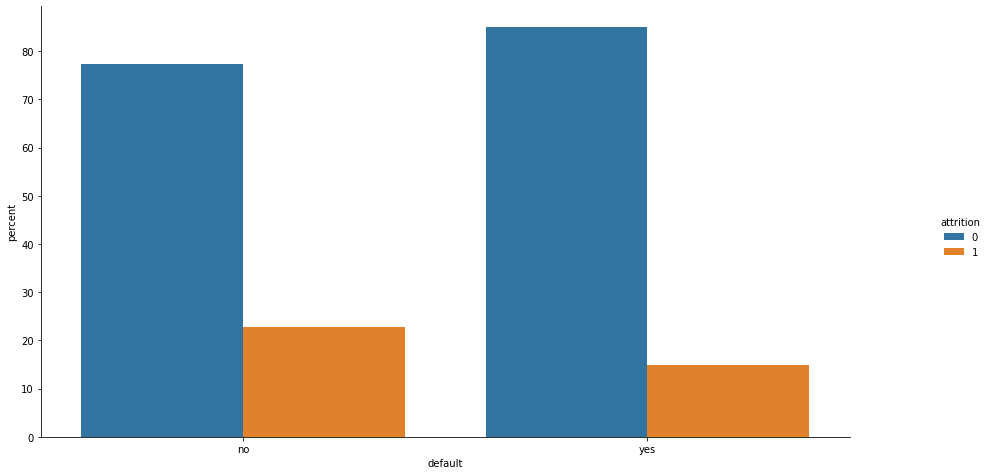

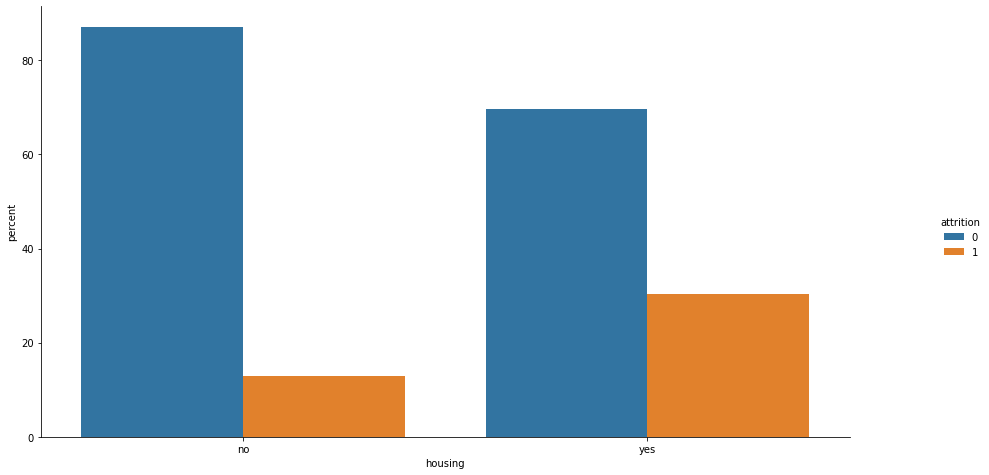

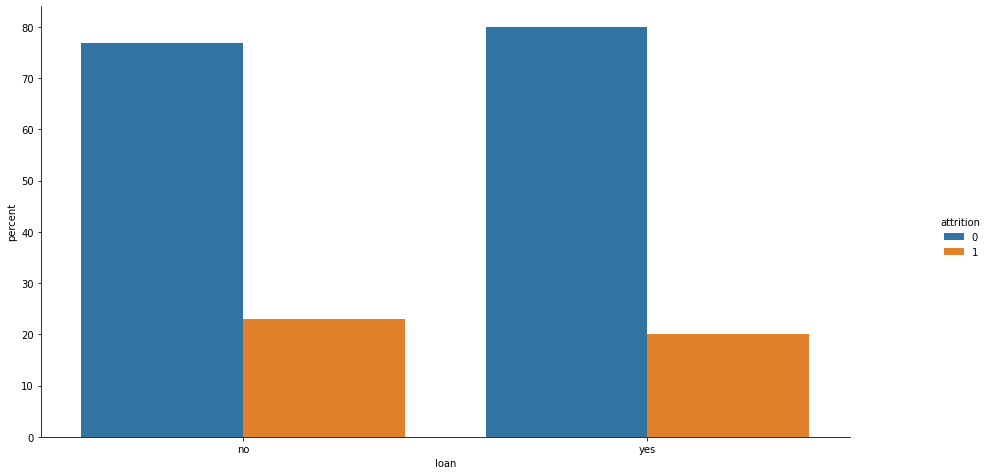

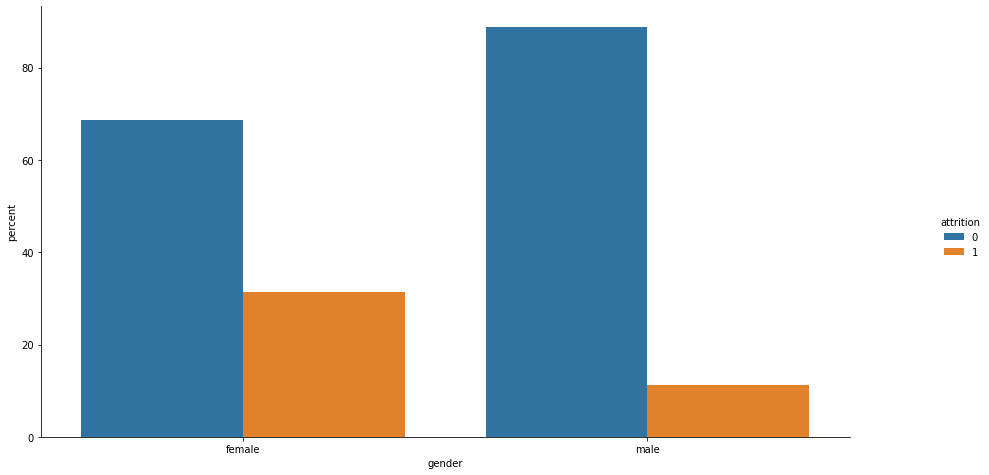

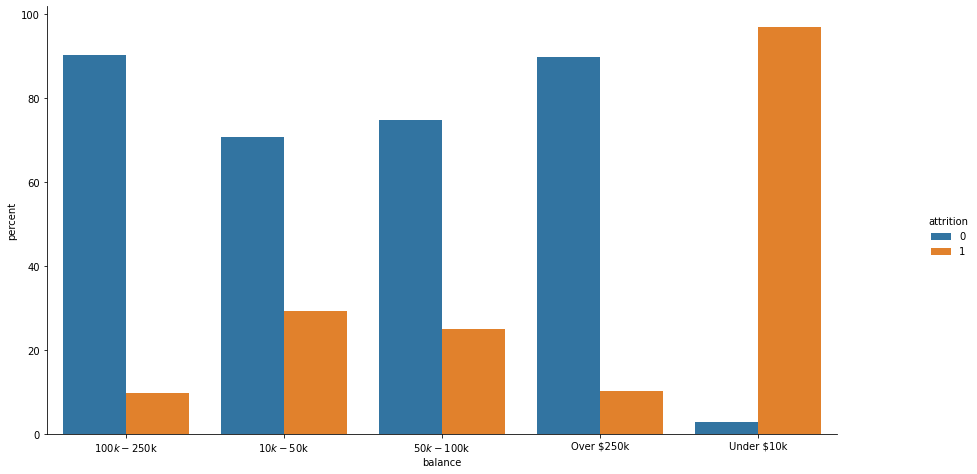

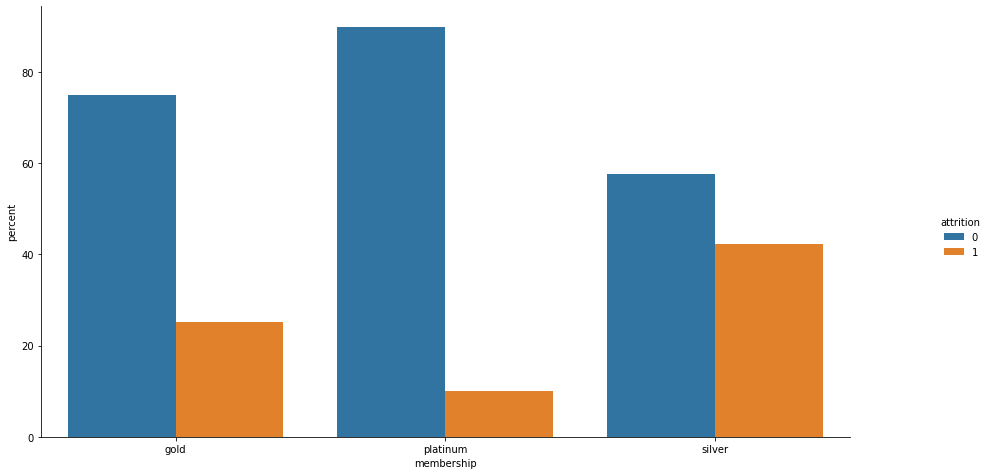

In [15]:
#same plots as above, but looking at proportions and not counts
fignum = 40
for i in cat_cols:
  plt.figure(fignum)
  x,y = i, 'attrition'
  g =(bankDataPandas
  .groupby(x)[y]
  .value_counts(normalize=True)
  .mul(100)
  .rename('percent')
  .reset_index()
  .pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))  
  
  g.fig.set_figwidth(15)
  g.fig.set_figheight(7)
  fignum = fignum+1

### **Split the Spark DataFrame Into Test and Train**

In [0]:
train, test   = bankData.randomSplit([0.7, 0.3], seed=12345)

In [17]:
train.count()

31454

In [18]:
test.count()

13757

### **Fit/Train ML Model**

In [0]:
#si1 = StringIndexer(inputCol="age_group", outputCol="age_group_index")
si2 = StringIndexer(inputCol="profession", outputCol="profession_index")
si3 = StringIndexer(inputCol="marital_status", outputCol="marital_status_index")
si4 = StringIndexer(inputCol="education", outputCol="education_index")
si5 = StringIndexer(inputCol="default", outputCol="default_index")
si6 = StringIndexer(inputCol="housing", outputCol="housing_index")
si7 = StringIndexer(inputCol="loan", outputCol="loan_index")
si8 = StringIndexer(inputCol="gender", outputCol="gender_index")
si9 = StringIndexer(inputCol="membership", outputCol="membership_index")

#ohe = OneHotEncoderEstimator(inputCols=["color_indexed"], outputCols=["color_ohe"])

col_target   =  'attrition'
#col_features =  ['age', 'charges', 'education_index']


col_features = ['age', 'charges', 'customer_contacts',
                'profession_index', 'marital_status_index', 'education_index',
                'default_index', 'housing_index', 'loan_index', 'gender_index', 'membership_index']

# Use a VectorAssembler to combine all the feature columns into a single vector column. 
va  = VectorAssembler(inputCols=col_features, outputCol="features")
#Since we will have more than 1 stage of feature transformations, we use a Pipeline to tie the stages together. 
rfc = RandomForestClassifier(featuresCol="features", labelCol=col_target, predictionCol="prediction", probabilityCol="probability", numTrees=25, maxDepth=5, maxBins=32, seed=12345)
pipeline = Pipeline(stages=[si2, si3, si4, si5, si6, si7, si8, si9 ,va,rfc])

In [0]:
model = pipeline.fit(train)

### **Make Predictions**

In [0]:
predictions = model.transform(test)
predictions.createOrReplaceTempView("predictions")

In [22]:
predictions.show(5)

+-------+---+---------+-------------+--------------+-----------+-------+-------+----+------+-------------+----------+-------+-----------------+---------+----------------+--------------------+---------------+-------------+-------------+----------+------------+----------------+--------------------+--------------------+--------------------+----------+
|    uid|age|age_group|   profession|marital_status|  education|default|housing|loan|gender|      balance|membership|charges|customer_contacts|attrition|profession_index|marital_status_index|education_index|default_index|housing_index|loan_index|gender_index|membership_index|            features|       rawPrediction|         probability|prediction|
+-------+---+---------+-------------+--------------+-----------+-------+-------+----+------+-------------+----------+-------+-----------------+---------+----------------+--------------------+---------------+-------------+-------------+----------+------------+----------------+--------------------+-

### **Evaluate Model Against Test DataFrame**

In [23]:
# Binary Evaluator to evaluate our model
bi_evaluator = BinaryClassificationEvaluator(labelCol=col_target, metricName='areaUnderROC')
areaunderroc = bi_evaluator.evaluate(predictions)
print("Area Under ROC: " + str(areaunderroc))

Area Under ROC: 0.9355160694162722


In [24]:
# Print True Positive vs. False Positives
predictions.groupBy('attrition','prediction').count().show()

+---------+----------+-----+
|attrition|prediction|count|
+---------+----------+-----+
|        1|       0.0|  694|
|        0|       0.0|10609|
|        1|       1.0| 2438|
|        0|       1.0|   16|
+---------+----------+-----+



In [0]:
bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='attrition')

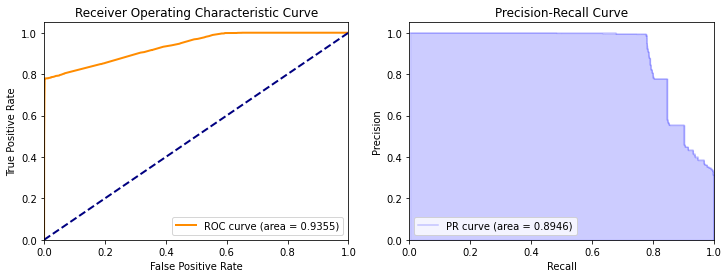

In [26]:
# PLOT ROC and Precision-Recall Curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

In [0]:
#Precision / Recall for various thresholds 
bcm.getMetricsByThreshold().filter('fpr between 0.19 and 0.20').toPandas()

In [28]:
# Confusion Matrix - for .5 threshold
bcm.print_confusion_matrix()

Predicted        
                 0       1
Actual 0   10609.0    16.0
       1     694.0  2438.0

In [0]:
#store confusion matrix into dataframe
confusion_matrix = bcm.print_confusion_matrix()

In [0]:
#pull out TP, TN, FP, FN from confusion_matrix dataframe
true_positive = confusion_matrix['Predicted'][1][1]
true_negative = confusion_matrix['Predicted'][0][0]
false_positive = confusion_matrix['Predicted'][1][0]
false_negative = confusion_matrix['Predicted'][0][1]

In [0]:
#calculate accuracy, m.e., precision, and recall 
accuracy = (true_positive + true_negative) / test.count()
misclassifiation_error =  1 - accuracy 
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

In [32]:
print("Accuracy: " + str(accuracy))
print("Misclassification Error: " + str(misclassifiation_error))
print("Recall: " + str(recall))

Accuracy: 0.9483899105909719
Misclassification Error: 0.051610089409028115
Recall: 0.7784163473818646


In [33]:
# Confusion Matrix with threshold specified 
bcm.print_confusion_matrix(0.4)

Predicted        
                 0       1
Actual 0   10609.0    16.0
       1     694.0  2438.0

In [34]:
#Feature Importance
feature_importance_vars = sorted([(col_features[i],feature) for i,feature in enumerate(model.stages[-1].featureImportances)], key=lambda x: x[1], reverse=True)
print('Feature Importances (descending):')
for f in feature_importance_vars:
    print(f)

Feature Importances (descending):
('charges', 0.49183349513677477)
('marital_status_index', 0.2594947721943153)
('customer_contacts', 0.19104391182809963)
('membership_index', 0.02751876699144313)
('age', 0.016605128806175297)
('profession_index', 0.0072824018213462635)
('housing_index', 0.006137507806412472)
('education_index', 4.888609544178616e-05)
('default_index', 1.356889687539138e-05)
('loan_index', 1.192090491304703e-05)
('gender_index', 9.639518202651334e-06)
